In [ ]:
!sudo apt-get install libportaudio2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (745 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 155222 files

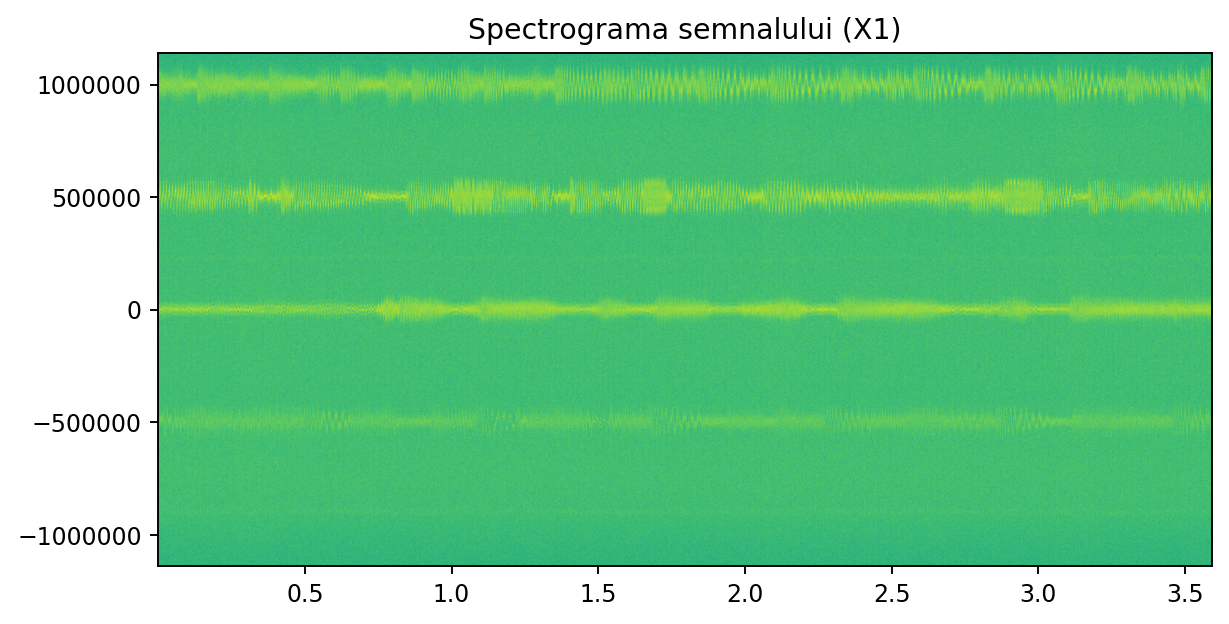

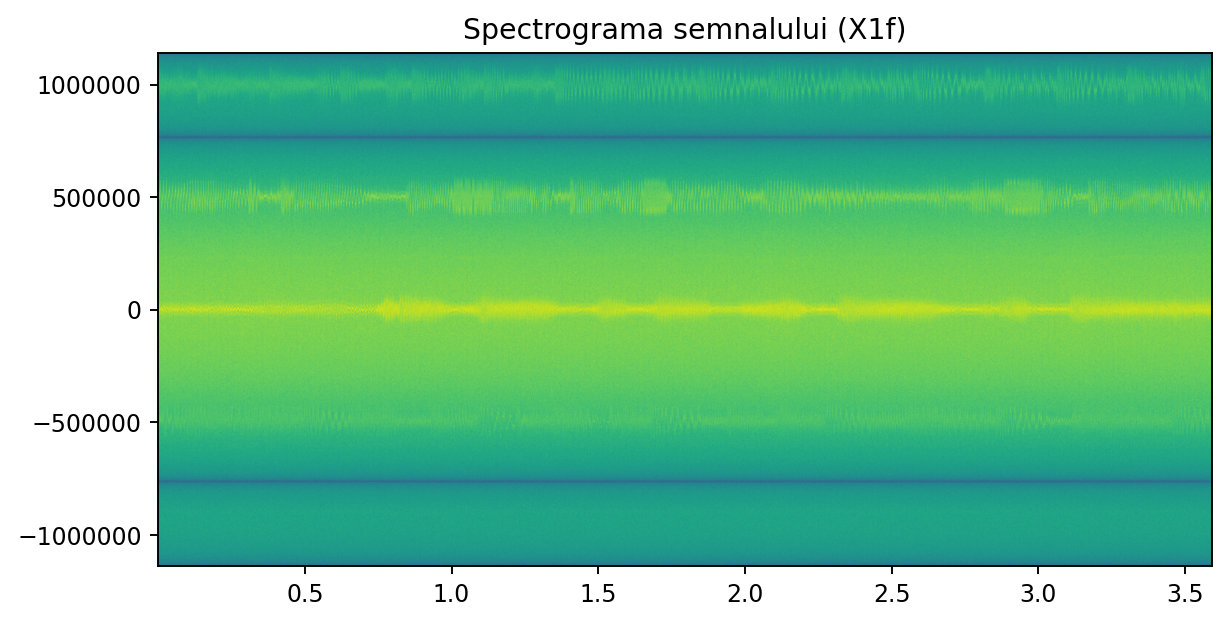

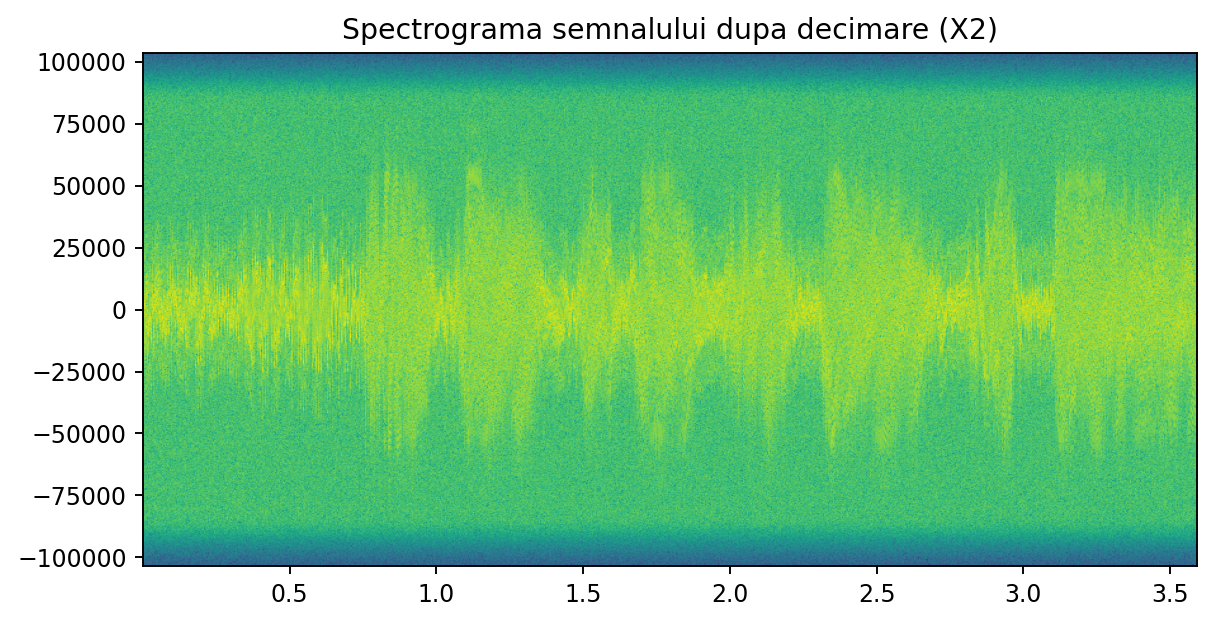

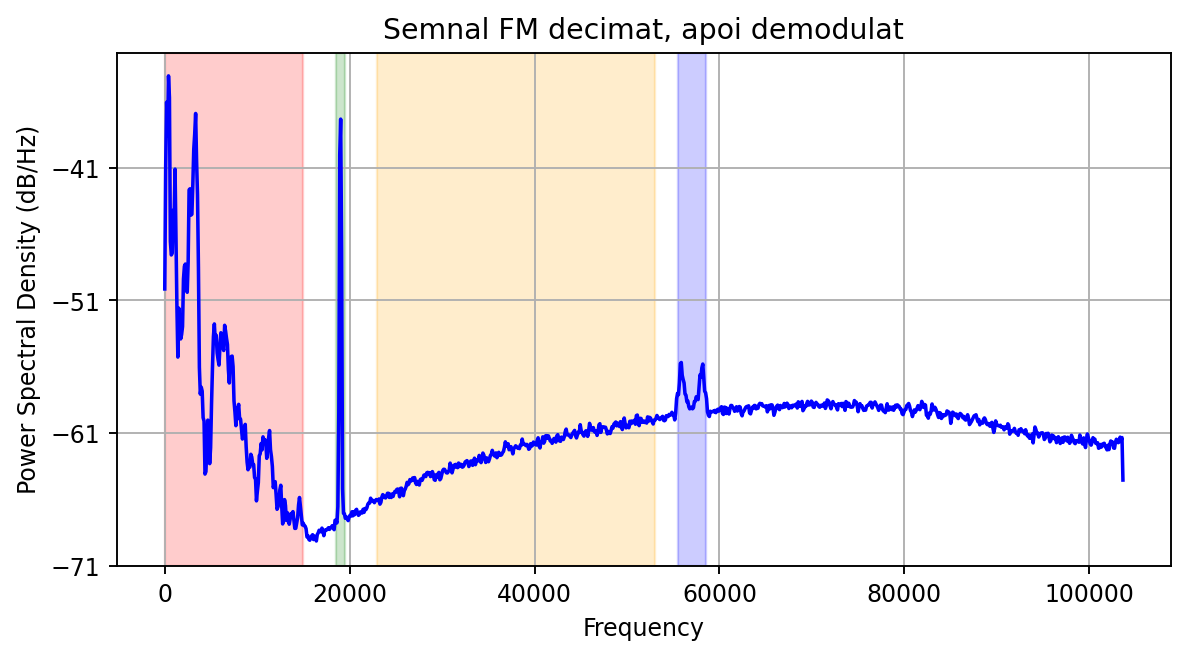

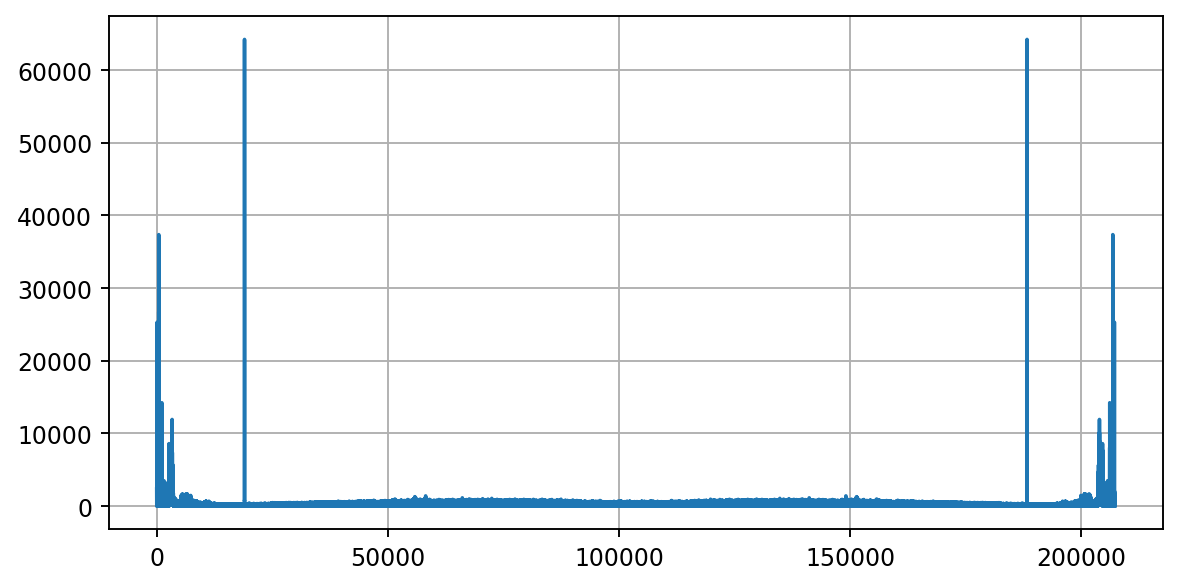

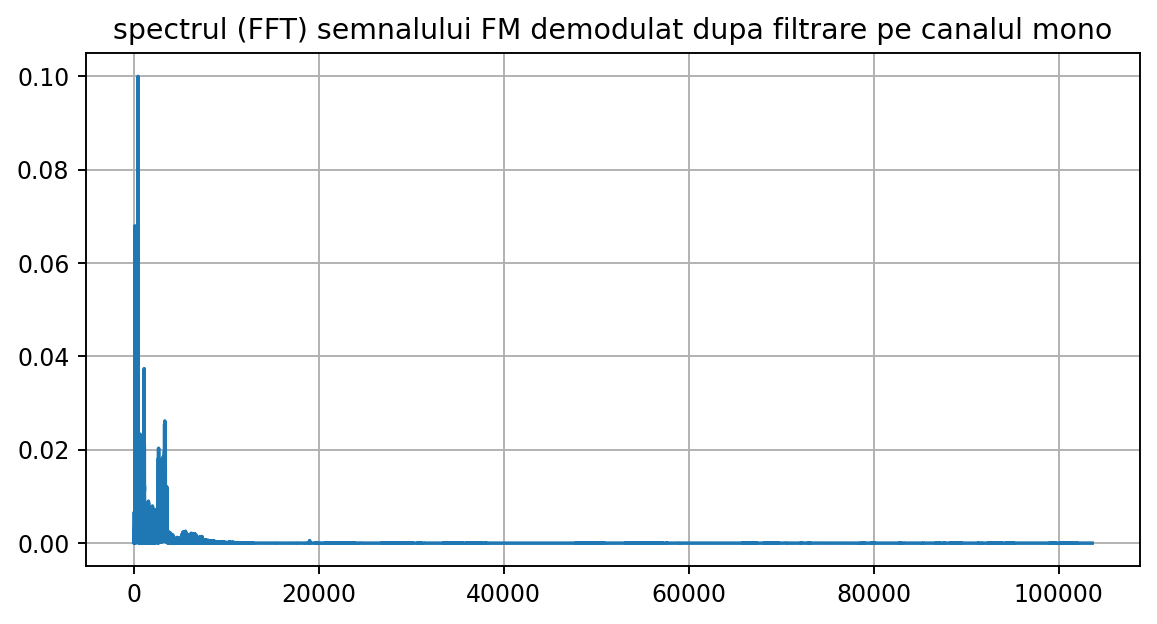

Press Enter to play audio from signal...
Am terminat!

Press Enter to continue...


''

In [ ]:
# -*- coding: utf-8 -*-
"""
    Laborator PS cu RTL-SDR
    Cod initial de Matei Simtinica
    Unele modificari de Marios Choudary

    Nota: trebuie instalate cateva lucruri pentru ca acest script sa functioneze:

    1. Python3 și pip pentru Python3 (acest script se bazeaza pe folosirea Python3)

    2. Install librtlsdr (pentru a putea folosi dispozitivul RTL-SDR)

    Pe MAC OS:
    sudo port install rtl-sdr

    Sau pentru brew:
    https://macappstore.org/librtlsdr/

    Pe Linux
    sudo apt-get install  librtlsdr-dev

    3. Install matplotlib, scipy, sounddevice pentru Python3:
    pip3 install matplotlib scipy sounddevice

"""

# from rtlsdr import RtlSdr # comentati asta daca nu folositi dispozitiv RTL
import matplotlib.pyplot as plt
import numpy
import numpy as np
import scipy.signal
import scipy.signal as signal
#from IPython.display import Audio
from scipy.fftpack import fft
import sounddevice as sd
from scipy.io.wavfile import write

plt.rcParams['figure.dpi'] = 170
plt.rcParams['figure.figsize'] = (8, 4)

# Setati aici 1 daca folositi un RTL-SDR, 0 altfel
use_sdr = 0

F_station = int(88.5e6) # Trinitas FM
Fs = 2280000            # frecventa de esantionare (samplerate)
N = 8192000             # numarul esantioanelor

if use_sdr == 0:
    x1 = np.load('x1.npy')
else:
    # initializati device-ul RTL-SDR
    sdr = RtlSdr()

    # setati parametri device-ului
    sdr.sample_rate = Fs
    sdr.center_freq = F_station
    sdr.gain = 'auto'

    # cititi semnalul brut
    x1 = sdr.read_samples(N)
    np.save('x1.npy', x1)

    # eliberati resursele device-ului
    sdr.close()
    
# plotati spectrograma semnalului
# Pentru detalii, vedeti aici: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html
plt.figure()
plt.specgram(x1, NFFT=2**10, Fs=Fs)
plt.title('Spectrograma semnalului (X1)')
plt.ylim(-Fs/2, Fs/2)
plt.ticklabel_format(style='plain')
plt.show(block=False)

# semnalele FM sunt difuzate pe o latime de banda de 200kHz
f_bw = 200000

# filtrarea semnalului
# TODO 1: creati un filtru trece-jos digital folosind scipy.signal.firwin
# 1. Selectati un numar de coeficienti (taps) ai filtrului (incercati 8, 16, 32)
taps = 8
# 2. Calculati frecventa de taiere (cutoff), ca raport intre
#    frecventa maxima de interes (e.g. f_bw) si fs/2
cutoff = f_bw / (Fs/2)
# 3. alegeti o fereastra pentru atenuarea DFT leakage rezultat din filtru (e.g. 'hamming')
fereastra = 'hamming'
# 4. folositi functia firwin din scipy.signal pentru a obtine coeficientii unui filtru FIR
coeficientii = scipy.signal.firwin(taps, cutoff, None, fereastra, True, True, None, Fs)
# 5. filtrati semnalul initial (x1) cu coeficientii obtinuti anterior, folosind functia lfilter din scipy.signal
ntaps = taps # incercati mai multe variante: 8, 16, 32, vedeti apoi diferentele, prin spectrograma urmatoare
fcut = cutoff # calculati cat este frecventa de cutoff necesara, ca o valoare intre 0 si 1, unde 1 corespunde lui fs/2
b = coeficientii # folositi signal.firwin pentru a obtine coeficientii (b) ai unui filtru trece-jos:
      # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html#scipy.signal.firwin
x1f = signal.lfilter(b, 1, x1)

# plotati spectrograma semnalului dupa filtrare
# TODO 2: faceti spectrograma, ca mai sus, dar pentru semnalul x1f
# Observati diferentele intre spectrograma semnalului initial si cel filtrat
# pentru diferite valori ale numarului de coeficienti ai filtrului (ntaps)
plt.figure()
plt.specgram(x1f, NFFT=2**10, Fs=Fs)
plt.title('Spectrograma semnalului (X1f)')
plt.ylim(-Fs/2, Fs/2)
plt.ticklabel_format(style='plain')
plt.show(block=False)

# decimare
# TODO 3: decimati (faceti subsampling) semnalul, astfel incat sa aveti noua frecventa
# de esantionare f_bw   (i.e. fs' = f_bw)
dec_rate = int(Fs / f_bw) # calculati factorul de decimare (raportul intre frecvente)
x2 = signal.decimate(x1f, dec_rate)

# noua frecventa de esantionare
Fs_new = Fs / dec_rate

# plotati spectrograma semnalului decimat
# TODO 4: afisati spectrograma pentru semnalul obtinut dupa decimare
plt.figure()
plt.specgram(x2, NFFT=2**10, Fs=Fs_new)
plt.title('Spectrograma semnalului dupa decimare (X2)')
plt.ticklabel_format(style='plain')
plt.show(block=False)

# demodulati semnalul FM
# TODO 5: demodulati semnalul FM prin folosirea unui discriminator simplu de frecvente
# 1. Folosind semnalul decimat (x2), obtineti o copie a acestuia dar intarziat cu un element (x2_int = x2[1:])
# 2. Calculati conjugatul acestui semnal intarziat (puteti folosi numpy.conj)
# 3. Inmultiti semnalul decimat (x2) cu semnalul intarziat conjugat
# 4. calculati faza (unghiul) semnalului rezultat din inmultirea precedenta (puteti folosi numpy.angle)
# Aceasta faza va fi direct proportionala cu semnalul transmis, asa ca poate fi folosita direct.
x2_int = x2[1:]
x2_int_conj = numpy.conj(x2_int) # calculati conjugatul cu numpy.conj
xx = x2[:-1] * x2_int_conj
x3 = numpy.angle(xx) # calculati faza semnalului inmultit (xx) folosind numpy.angle


# vizualizati semnalul FM obtinut prin afisarea puterii spectrale (power spectral density)
# zonele colorate corespund componentelor relevante semnalului
# rosu -> audio mono
# portocaliu -> audio stereo
plt.figure()
plt.psd(x3, NFFT=2048, Fs=Fs_new, color='blue')
plt.title('Semnal FM decimat, apoi demodulat')
plt.axvspan(0,             15000,         color='red',    alpha=0.2)
plt.axvspan(19000-500,     19000+500,     color='green',  alpha=0.2)
plt.axvspan(19000*2-15000, 19000*2+15000, color='orange', alpha=0.2)
plt.axvspan(19000*3-1500,  19000*3+1500,  color='blue',   alpha=0.2)
plt.show(block=False)

# Calculati si afisati FFT pentru semnalului demodulat
# TODO 6:
# 1. Calculati FFT din x3 prin functia fft din scipy.fftpack
# 2. afisati valoarea absoluta a spectrului (np.abs) intre 0 si fs/2
# Nota: puteti folosi np.linspace pentru a crea un vector de frecvente intre 0 si fs, util la plot
yf = scipy.fftpack.fft(x3) # calculati aici spectrul lui x3 folosind scipy.fftpack.fft
nf = len(yf)
xf = np.linspace(0, Fs_new, nf)
plt.figure()
plt.plot(xf, np.abs(yf))
plt.grid()
plt.show(block=False)

# extragerea semnalului audio (mono) prin filtrare si decimare
# TODO 7:
# 1. filtrati semnalul precedent (x3) pentru a retine doar componentele intre 0 si 15 kHz (corespunde semnalului mono)
# 2. Calculati si afisati FFT pentru semnalul filtrat si comparati cu FFT-ul semnalului precedent (nefiltrat)
# 3. decimati semnalul astfel incat sa aveti frecventa finala de esantionare f_audio = 44100 Hz pentru a-l putea asculta
ntaps2 = 32
fmaxa = 15000
fcut2 = fmaxa / (Fs / 2) # calculati frecventa de cutoff necesara pentru a opri doar semnalele intre 0 si 15 kHz (tot in raport cu fs/2)
b2 = signal.firwin(ntaps2, fcut2, window='hamming')
x3f = signal.lfilter(b2, 1, x3)

yff = fft(x3f)
nff = len(yff)
nff2 = int(nff/2)
xff = np.linspace(0, Fs_new, nff)
plt.figure()
plt.plot(xff[0:nff2], 2.0/nff * np.abs(yff[0:nff2]))
plt.title('spectrul (FFT) semnalului FM demodulat dupa filtrare pe canalul mono')
plt.grid()
plt.show(block=False)

f_audio = 44100
dec_audio = int(Fs_new / f_audio) # calculati factorul de decimare pentru a face subsampling de la Fs_new la f_audio
Fs_audio = Fs_new / dec_audio
xa = signal.decimate(x3f, dec_audio)

input("Press Enter to play audio from signal...")

# Redarea semnalului si salvarea lui ca wav
xs = np.int16(xa/np.max(np.abs(xa)) * 32767)
#sd.play(xs, f_audio)
write('x1.wav', f_audio, xs)

print("Am terminat!\n")
input("Press Enter to continue...")